# Result analysis

## Loss

In [26]:
import glob
import json
import os

import matplotlib.pyplot as plt
import torch
from bouncing_ball.dataloaders.bouncing_data import BouncingBallDataLoader
from kalman_vae import KalmanVariationalAutoencoder
from natsort import natsorted

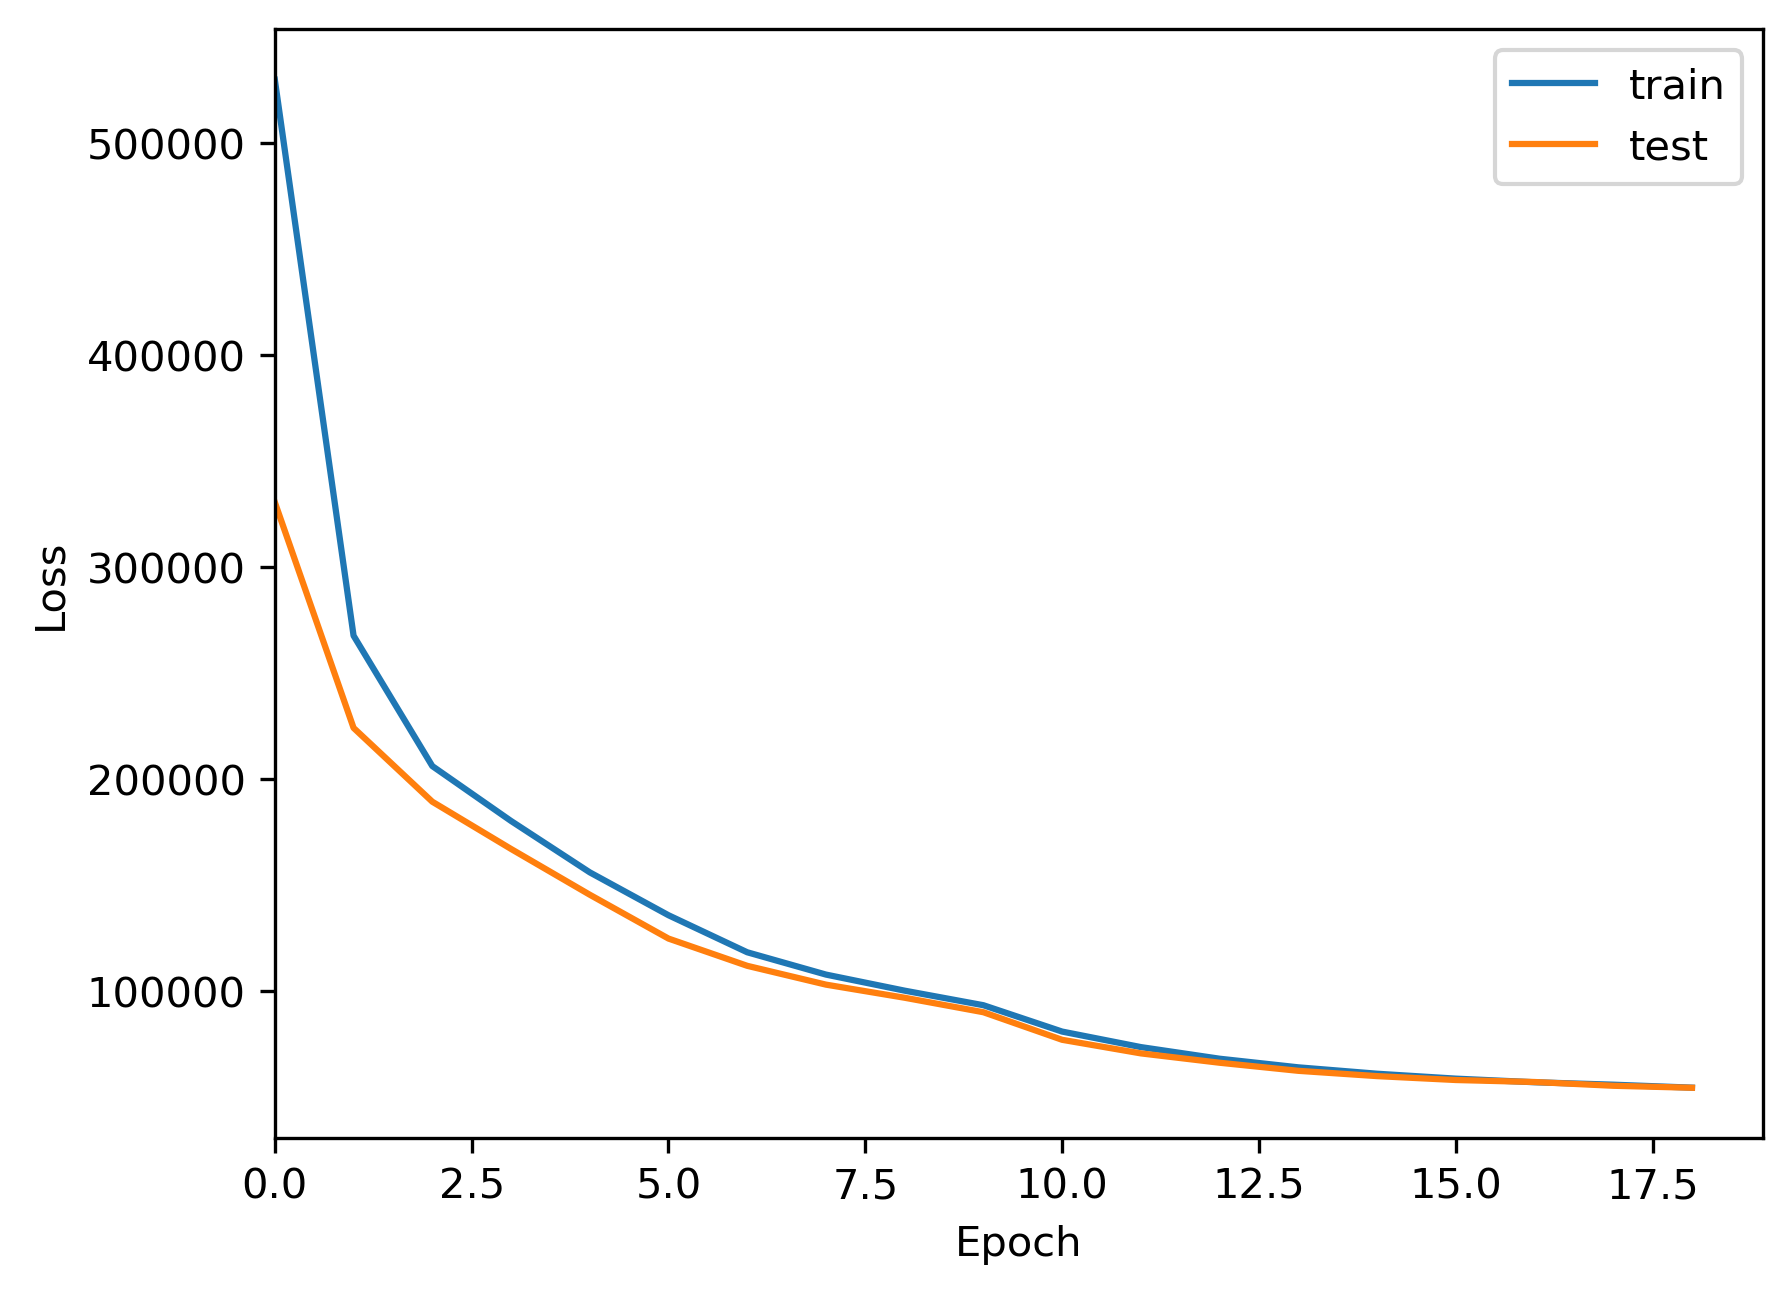

In [27]:
train_losses = []
test_losses = []

for file in natsorted(glob.glob('checkpoints/bouncing_ball/state-*.pth')):
    checkpoint = torch.load(file)
    train_losses.append(checkpoint['train_loss'])
    test_losses.append(checkpoint['test_loss'])
    
plt.figure(dpi=300)
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xlim(0, None)
# plt.yscale("log")
plt.show()

## Data visualization

In [9]:
data_index = 0

In [10]:
dataloader_test = BouncingBallDataLoader(root_dir='bouncing_ball/datasets/bouncing-ball/test')
data = dataloader_test[data_index]

In [11]:
for i, data in enumerate(dataloader_test):
    print(data.shape)
    break

(50, 1, 16, 16)


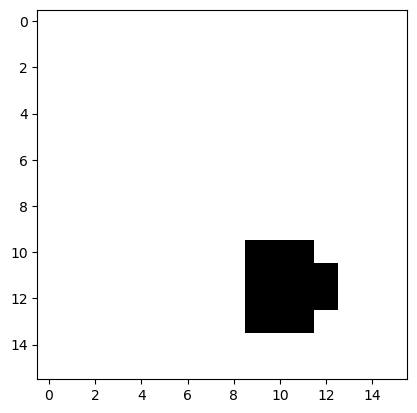

In [12]:
plt.imshow(data[0][0], vmin=0, vmax=1, cmap="Greys")

In [13]:
image_size = data.shape[2:]
image_channels = data.shape[1]

## Weights for transition matrix $A$

In [14]:
checkpoint = torch.load(file)

In [15]:
kvae = KalmanVariationalAutoencoder(
    image_size=image_size,
    image_channels=image_channels,
    a_dim=2,
    z_dim=4,
    K=3,
    decoder_type='bernoulli',
)

In [16]:
kvae.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [17]:
data_batch = torch.Tensor(data).unsqueeze(1)

In [18]:
data_batch.shape

torch.Size([50, 1, 1, 16, 16])

In [19]:
seq_length = data_batch.shape[0]
batch_size = data_batch.shape[1]

In [20]:
as_dist = kvae.encoder(data_batch.reshape(-1, *data_batch.shape[2:]))
as_mean = as_dist.loc.unsqueeze(1)

In [21]:
as_mean.shape

torch.Size([50, 1, 2])

In [22]:
weights = kvae.state_space_model.weight_model(as_mean)

In [23]:
for step, (image, weight) in enumerate(zip(data_batch, weights)):
    image = image > 0.5
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(f"$t = {step}$")
    axes[0].imshow(image[0][0], vmin=0, vmax=1, cmap="Greys", aspect='equal')
    axes[0].set_adjustable('box') 
    axes[1].bar(["0", "1", "2"], weight[0].detach().numpy())
    axes[1].set_ylim(0, 1)
    axes[0].set_title("image $\mathbf{x}_t$")
    axes[1].set_title("weight $\mathbf{k}_t$")
    pos_img = axes[0].get_position()
    pos_bar = axes[1].get_position()
    axes[1].set_position([pos_bar.x0, pos_img.y0, pos_bar.width, pos_img.height])
    fig.savefig(f"analysis/weight-{step}.png")
    plt.close()

In [24]:
!ffmpeg -framerate 10 -i analysis/weight-%d.png -c:v libopenh264 -r 30 -pix_fmt yuv420p analysis/weights.mp4 -y

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1674566251848/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1674566251848/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-pthreads --disable-gpl --enable-libaom --enable

In [25]:
from IPython.display import Video

Video("./analysis/weights.mp4")

### Check if all learnable parameters change

In [21]:
checkpoint_10 = torch.load('checkpoints/bouncing_ball/state-10.pth')
checkpoint_20 = torch.load('checkpoints/bouncing_ball/state-20.pth')

In [22]:
for key in checkpoint_10["model_state_dict"]:
    sq_diff_mean = ((- checkpoint_10["model_state_dict"][key] + checkpoint_20["model_state_dict"][key])**2).mean()
    print(key, sq_diff_mean)

encoder.conv1.weight tensor(0.0023)
encoder.conv1.bias tensor(0.0006)
encoder.conv2.weight tensor(0.0007)
encoder.conv2.bias tensor(8.2684e-06)
encoder.conv3.weight tensor(0.0003)
encoder.conv3.bias tensor(6.8638e-05)
encoder.fc_mean.weight tensor(0.0025)
encoder.fc_mean.bias tensor(1.3057e-06)
encoder.fc_std.weight tensor(0.0007)
encoder.fc_std.bias tensor(4.7157e-05)
decoder.fc.weight tensor(0.0009)
decoder.fc.bias tensor(0.0020)
decoder.deconv1.weight tensor(0.0010)
decoder.deconv1.bias tensor(0.0006)
decoder.deconv2.weight tensor(0.0010)
decoder.deconv2.bias tensor(0.0002)
decoder.deconv3.weight tensor(0.0036)
decoder.deconv3.bias tensor(6.1640e-07)
state_space_model.mat_A_K tensor(0.0177)
state_space_model.mat_C_K tensor(0.0152)
state_space_model.mat_Q_L tensor(0.0076)
state_space_model.mat_R_L tensor(0.0291)
state_space_model.weight_model.lstm.weight_ih_l0 tensor(0.0031)
state_space_model.weight_model.lstm.weight_hh_l0 tensor(0.0106)
state_space_model.weight_model.lstm.bias_ih_l0